# Are the recalls more schematic than the stories themselves?

## Calculating 33 (using words as data points) and 34 (using participants as data points)



## Also includes the SCHEMA EFFECT analysis: Loc_corr_subj_i_story_j - Loc_corr_story_j

#### finding each participants avg loc/soc correlation and then subtracting the loc_corr_story

## Also includes the CORRELATION between # of words and avg word correlation 

#### 5/1/21


In [1]:
import pandas as pd
import numpy as np
import plotly.graph_objs as go
import plotly.plotly as py
import plotly
import os
import glob
import math
import statistics
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import copy
from random import randrange
from sklearn.metrics import jaccard_score
import random
from sklearn.preprocessing import normalize
from sklearn.linear_model import LinearRegression
from scipy import stats
from sklearn import datasets, linear_model


from sklearn.decomposition import PCA #for cluster analysis
from gensim.models import KeyedVectors #for word embeddings
import matplotlib.pyplot as plt #for plotting
import os #for importing
import pickle #for loading transcripts
from scipy.stats import pearsonr 

# from _DRAFT_20200604_functions import * #includes constants and score function
from tqdm import tqdm_notebook #for progress bar

#Import wordcloud
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

%autosave 5

Autosaving every 5 seconds


# 0. Import recalls, and uncentered story and template vectors and sums 

In [8]:
# import recalls and sums
recalls = pickle.load( open( 'fr_recalls', "rb" ) )
sums = pickle.load( open( "fr_sums", "rb" ) )

#import individual words of stories
granstories = pickle.load( open( 'gran_stories', "rb" ) )

#import non-centered story, template
templates = pickle.load( open( 'template_vectors', "rb" ) )
stories = pickle.load( open( 'actual_story_vectors', "rb" ) )

In [6]:
recalls[21][1]

array([['Senna and his fiancee went to a restaurant to supposably commemorate on the new tomatoes that they grew but Senna\'s plan was to purpose to her on that day. They ordered what they wanted to eat and they started to talk about how they met and more. Then after they ate the attendant gave Senna\'s fiancee a cake with the wedding ring on top of it, and thats when Senna purposed to her in which she replied with a "Yes" and the other clients started applauding.',
        '/Users/alexreblando/Documents/Documents - Alex’s MacBook Air/GitHub/data_analysis_ebs/online_experiment/data/pilot1/7/PARTICIPANT_1_online_exp_2020-05-09_01h05.05.369',
        '5d0e2a06facd7500197a46e3'],
       ["Sienna and Alvira went to a restaurant, it had a beach view. They sat down with Sienna hoping to propose with a ring that had 3 canary yellow diamonds. They ordered food and really liked the food. They recalled their happy times together. After Sienna got down on one knee and proposed to Alvira's delight

## Word to Vec

In [10]:
wikipath = 'rolando/wiki-news-300d-1M.vec'
wv_model = KeyedVectors.load_word2vec_format(wikipath)

In [11]:
wv_dim = 300

# FastText preprocessing, based on bittlingmayer/ft_wiki_preproc.py
# Remove special characters, put spaces between all tokens
SUB = ["s/’/'/g", "s/′/'/g", "s/''/ /g", "s/'/ ' /g", 's/“/"/g', 's/”/"/g', 's/"/ /g', "s/\\./ \\. /g", "s/<br \\/>/ /g", "s/, / , /g", "s/(/ ( /g", "s/)/ ) /g", "s/\\!/ \\! /g", "s/\\?/ \\? /g", "s/\\;/ /g", "s/\\:/ /g", "s/-/ - /g", "s/=/ /g", "s/=/ /g", "s/*/ /g", "s/|/ /g", "s/«/ /g", 
       "s/…/ /g", "s/‘/ /g", "s/í/ /g", "s/ñ/ /g", "s/\x84/ /g", "s/î/ /g", "s/ó/ /g", "s/\x83/ /g", "s/ï/ /g", "s/õ/ /g",
       "s/ò/ /g", "s/,/ /g", "s/ô/ /g", "s/\x92/ /g", "s/é/ /g", "s/\x8e/ /g", "s/â\x80¦/ /g", "s/\x91/ /g", "s/\x93/ /g",
       "s/\x94/ /g", "s/ã®/ /g", "s/ã¨/ /g", "s/ã©/ /g",
       "s/\â\x80\x99/ /g", "s/â\x80\x9c/ /g", "s/â\x80\x9d/ /g", "s/â\x80\x99/ /g", "s/â\x80\x9c/ /g", "s/â\x80\x98/ /g",
       "s/â/ /g"]

def __normalize_text(s):
    for sg in SUB:
        rep = sg.replace('\\','').split('/')
        s = s.replace(rep[1], rep[2])
    s = s.replace('/',' ')
    return s

def __spaces(s):
    return ' '.join(s.split())

def __digits(s):
    return ''.join(filter(lambda c: not c.isdigit(), s))

# def preproc(s):
#     return __punctuation(__spaces(__digits(__normalize_text(s.lower()))))

def preproc(s):
    return (__spaces(__digits(__normalize_text(s.lower()))))

def __punctuation(s):
    return s.translate(str.maketrans('', '', string.punctuation))

def word2vecSent(sentence, model = 'fasttext'):
    wv_dim = 300 #for glove and fasttext
    
    if model == 'glove':
        wvmodel = glove_model
    elif model == 'fasttext':
        wvmodel = wv_model
        
    words = preproc(sentence).split(' ')
    wv = np.zeros((len(words), wv_dim))
    for i in range(len(words)):
        if words[i] in wvmodel.vocab:
            wv[i,:] = wvmodel.word_vec(words[i])
    
    return words, wv


# Recalls: Concatenate words and word vectors in parallel across all participants in a story

In [12]:
stories = [11, 12, 13, 14, 21, 22, 23, 24, 31, 32, 33, 34, 41, 42, 43, 44]
all_words = {}
all_wvs = {}
#priming type order
all_priming = {}
# all_words + priming layer
all_wvs_p = {}

# structure all_word_p
for story in stories:
    all_wvs_p[story] = {0:{}, 1:{}, 2:{}}


#iterate through all recalls in a story and concatente words and wvs of all stories
for key in recalls:
    words = np.zeros((0,1))
    wvs = np.zeros((0,300))
    priming = np.zeros((0,1))
    for i in range(0,3):
        for j in range(0,len(recalls[key][i])):
            p_words, p_wvs = word2vecSent(recalls[key][i][j][0])
            # reshape p_words
            p_words = np.array(p_words)
            p_words = p_words.reshape(p_words.shape[0],-1)
            p_priming = np.zeros(p_words.shape)
            p_priming = p_priming + i
            # stack p_words and p_wvs
            words = np.vstack((words, p_words))
            wvs = np.vstack((wvs, p_wvs))
            priming = np.vstack((priming, p_priming))
            all_wvs_p[key][i][j] = p_wvs
    all_words[key] = words
    all_wvs[key] = wvs
    all_priming[key] = priming 

# 2. Centering all words + story wvs + template wvs

In [13]:
#Concatenate all words from recall

concat = np.zeros((0,300))


for key in all_wvs:
    concat = np.vstack((concat, all_wvs[key]))
            
print(concat.shape)
    
for key in granstories:
    concat = np.vstack((concat, granstories[key]['wvs']))
    
for key in templates:
    concat = np.vstack((concat, templates[key]))

print(concat.shape)

centering_vec = np.mean(concat, axis = 0)

# template vectors

for key in templates:
    templates[key] = templates[key] - centering_vec
    
# recall vectors using all_wvs_p

for key in all_wvs_p:
    for i in range(0, 3):
        for sub in all_wvs_p[key][i].keys():
            for j in range(0, all_wvs_p[key][i][sub].shape[0]):
                all_wvs_p[key][i][sub][j] = all_wvs_p[key][i][sub][j] - centering_vec
            
#story vectors

#make new dict with int key instead of string
for key in granstories:
    granstories[key]['wvs'] = granstories[key]['wvs'] - centering_vec

(42875, 300)
(53012, 300)


## template regression

In [14]:
schema_order = [1, 2, 3, 4, 10, 20, 30, 40]

new_templates = {}

for template in templates:
    new_input = np.zeros((300,0))
    for other_template in schema_order:
        if other_template == template:
            pass
        else:
            new_input = np.concatenate((new_input, templates[other_template].reshape(templates[other_template].shape[0],-1)), axis = 1)
    ## regression 
    output = np.copy(templates[template])
    #output = output.reshape(output.shape[0],-1)
    model = LinearRegression().fit(new_input, output)
    ## Is subtracting the intercept correct?? 
    new_vec = output - np.dot(model.coef_, new_input.T)- model.intercept_
    new_templates[template] = new_vec

# STORY correlation 
## LOC template correlation with story words
### standard across both analyses

In [15]:
### A. Correlate each word with the LOC WV
loc_cors = {}

for key in granstories.keys():
    n = granstories[key]['wvs'].shape[0]
    this_loc_cors = np.zeros((n,1))
    loc = int(key)%10
    this_loc = new_templates[int(loc)].reshape(new_templates[int(loc)].shape[0], -1)
    for i in range(0, n):
        this_wv = granstories[key]['wvs'][i].reshape(granstories[key]['wvs'][i].shape[0], -1)
        this_correl = np.corrcoef(this_loc.T, this_wv.T)
        this_loc_cors[i] = this_correl[0,1]
    loc_cors[int(key)] = np.ravel(this_loc_cors)
    
#avg loc cors

loc_stories = {}

for key in loc_cors:
    loc_stories[int(key)] = np.mean(loc_cors[key])

## SOC template correlation with story words


In [16]:
### A. Correlate each word with the LOC WV
soc_cors = {}

for key in granstories.keys():
    n = granstories[key]['wvs'].shape[0]
    this_soc_cors = np.zeros((n,1))
    soc = round(int(key)/10)*10
    this_soc = new_templates[int(soc)].reshape(new_templates[int(soc)].shape[0], -1)
    for i in range(0, n):
        this_wv = granstories[key]['wvs'][i].reshape(granstories[key]['wvs'][i].shape[0], -1)
        this_correl = np.corrcoef(this_soc.T, this_wv.T)
        this_soc_cors[i] = this_correl[0,1]
    soc_cors[int(key)] = np.ravel(this_soc_cors)
    
#avg loc cors

soc_stories = {}

for key in soc_cors:
    soc_stories[int(key)] = np.mean(soc_cors[key])

# RECALL correlations
## *LOC* correlations with recalls
### 1. subtract loc_stories[key] from each word in all_wvs_p

In [17]:
new_wvs = copy.deepcopy(all_wvs_p)

In [18]:
### A. Correlate each word with the LOC WV
re_loc_cors = {}

# structure loc_cors same as all_wvs_p
for story in stories:
    re_loc_cors[story] = {0:{}, 1:{}, 2:{}}

for key in all_wvs:
    loc = key%10
    this_loc = new_templates[loc].reshape(new_templates[loc].shape[0], -1)
    for i in range(0,3):
        for partc in all_wvs_p[key][i]:
            n_words = all_wvs_p[key][i][partc].shape[0]
            this_loc_cors = np.zeros((n_words,1))
            for j in range(0, n_words):
                this_wv = new_wvs[key][i][partc][j].reshape(new_wvs[key][i][partc][j].shape[0], -1)
                this_correl = np.corrcoef(this_loc.T, this_wv.T)
                this_loc_cors[j] = this_correl[0,1]
            re_loc_cors[key][i][partc] = this_loc_cors

# *SOC* correlations with recalls


In [19]:
### A. Correlate each word with the SOC WV
re_soc_cors = {}

# structure soc_cors same as all_wvs_p
for story in stories:
    re_soc_cors[story] = {0:{}, 1:{}, 2:{}}

for key in all_wvs:
    soc = round(key/10)*10
    this_soc = new_templates[soc].reshape(new_templates[soc].shape[0], -1)
    for i in range(0,3):
        for partc in all_wvs_p[key][i]:
            n_words = all_wvs_p[key][i][partc].shape[0]
            this_soc_cors = np.zeros((n_words,1))
            for j in range(0, n_words):
                this_wv = new_wvs[key][i][partc][j].reshape(new_wvs[key][i][partc][j].shape[0], -1)
                this_correl = np.corrcoef(this_soc.T, this_wv.T)
                this_soc_cors[j] = this_correl[0,1]
            re_soc_cors[key][i][partc] = this_soc_cors

# Find the means over ALL WORDS
## no averaging by participant
### 1. No differentiation of priming

In [20]:
# Story 
loc_story = np.zeros((0,1))
soc_story = np.zeros((0,1))

# Loc-story all words
for story in stories:
    loc_story = np.vstack((loc_story, loc_cors[story].reshape(loc_cors[story].shape[0], -1)))

story_loc_avg = np.nanmean(loc_story)
print('story_loc_avg: ', story_loc_avg)

# Soc recall all words
for story in stories:
    soc_story = np.vstack((soc_story, soc_cors[story].reshape(soc_cors[story].shape[0], -1)))

story_soc_avg = np.nanmean(soc_story)
print('story_soc_avg: ', story_soc_avg)

# Recall
loc_recall = np.zeros((0,1))
soc_recall = np.zeros((0,1))

# Loc recall all words
for story in stories:
    for i in range(0,3):
        for sub in re_loc_cors[story][i].keys():
            loc_recall = np.vstack((loc_recall, re_loc_cors[story][i][sub]))

recall_loc_avg = np.nanmean(loc_recall)
print('recall_loc_avg: ', recall_loc_avg)

# Soc recall all words
for story in stories:
    for i in range(0,3):
        for sub in re_soc_cors[story][i].keys():
            soc_recall = np.vstack((soc_recall, re_soc_cors[story][i][sub]))

recall_soc_avg = np.nanmean(soc_recall)
print('recall_soc_avg: ', recall_soc_avg)
                


story_loc_avg:  0.012769744401489837
story_soc_avg:  0.011893715116330443
recall_loc_avg:  0.018600546898801966
recall_soc_avg:  0.0185591715850262


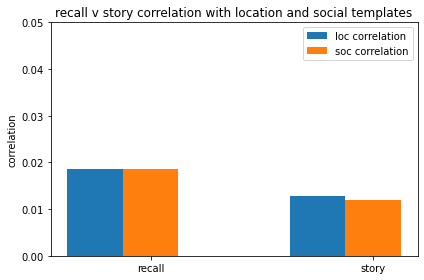

In [21]:
# loc correlation
loc_plot = np.zeros((2,1))

# soc correlation
soc_plot = np.zeros((2,1))

# assign values
# correlation with loc
loc_plot[0] = recall_loc_avg
loc_plot[1] = story_loc_avg


#proportion that are soc
soc_plot[0] = recall_soc_avg
soc_plot[1] = story_soc_avg

loc_plot = loc_plot.ravel()
soc_plot = soc_plot.ravel()

#labels
labels = ['recall', 'story']

x = np.arange(len(labels))  # the label locations
width = 0.25  # the width of the bars

fig, ax = plt.subplots()

rects1 = ax.bar(x, loc_plot, width, label='loc correlation')
rects2 = ax.bar(x + width, soc_plot, width, label='soc correlation')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('correlation')
ax.set_title('recall v story correlation with location and social templates')
ax.set_xticks(x + width)
ax.set_xticklabels(labels)
ax.legend()
ax.set_ylim([0, .05])
fig.tight_layout()
plt.savefig('templates.png')
plt.show()




# Finding Means of EACH PRIMING GROUP

In [22]:
## NP

# Recall
loc_recall_np = np.zeros((0,1))
soc_recall_np = np.zeros((0,1))

# Loc recall all words
for story in stories:
    for sub in re_loc_cors[story][0].keys():
            loc_recall_np = np.vstack((loc_recall, re_loc_cors[story][0][sub]))

recall_loc_avg_np = np.nanmean(loc_recall_np)
print('recall_loc_avg_np: ', recall_loc_avg_np)

# Soc recall all words
for story in stories:
    for sub in re_soc_cors[story][0].keys():
            soc_recall_np = np.vstack((soc_recall_np, re_soc_cors[story][0][sub]))

recall_soc_avg_np = np.nanmean(soc_recall_np)
print('recall_soc_avg_np: ', recall_soc_avg_np)


## LOC_______________________________________________________________

# Recall
loc_recall_loc = np.zeros((0,1))
soc_recall_loc = np.zeros((0,1))

# Loc recall all words
for story in stories:
    for sub in re_loc_cors[story][1].keys():
            loc_recall_loc = np.vstack((loc_recall_loc, re_loc_cors[story][1][sub]))

recall_loc_avg_loc = np.nanmean(loc_recall_loc)
print('recall_loc_avg_loc: ', recall_loc_avg_loc)

# Soc recall all words
for story in stories:
    for sub in re_soc_cors[story][1].keys():
            soc_recall_loc = np.vstack((soc_recall_loc, re_soc_cors[story][1][sub]))

recall_soc_avg_loc = np.nanmean(soc_recall_loc)
print('recall_soc_avg_loc: ', recall_soc_avg_loc)

## SOC___________________________________________________________________________________

# Recall
loc_recall_soc = np.zeros((0,1))
soc_recall_soc = np.zeros((0,1))

# Loc recall all words
for story in stories:
    for sub in re_soc_cors[story][2].keys():
            loc_recall_soc = np.vstack((loc_recall_soc, re_loc_cors[story][2][sub]))

recall_loc_avg_soc = np.nanmean(loc_recall_soc)
print('recall_loc_avg_soc: ', recall_loc_avg_soc)

# Soc recall all words
for story in stories:
    for sub in re_soc_cors[story][2].keys():
            soc_recall_soc = np.vstack((soc_recall_soc, re_soc_cors[story][2][sub]))

recall_soc_avg_soc = np.nanmean(soc_recall_soc)
print('recall_soc_avg_soc: ', recall_soc_avg_soc)

recall_loc_avg_np:  0.018643126117484504
recall_soc_avg_np:  0.0185415847246644
recall_loc_avg_loc:  0.01968475453663062
recall_soc_avg_loc:  0.019343687698304732
recall_loc_avg_soc:  0.01785713418353328
recall_soc_avg_soc:  0.017782647602720452


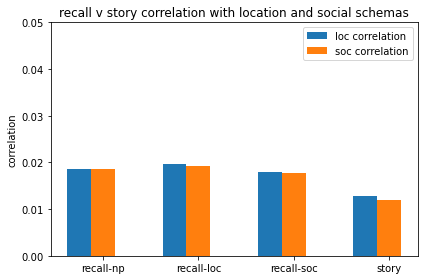

In [23]:
# loc correlation
loc_plot = np.zeros((4,1))

# soc correlation
soc_plot = np.zeros((4,1))

# assign values
# correlation with loc
loc_plot[0] = recall_loc_avg_np
loc_plot[1] = recall_loc_avg_loc
loc_plot[2] = recall_loc_avg_soc
loc_plot[3] = story_loc_avg


#proportion that are soc
soc_plot[0] = recall_soc_avg_np
soc_plot[1] = recall_soc_avg_loc
soc_plot[2] = recall_soc_avg_soc
soc_plot[3] = story_soc_avg

loc_plot = loc_plot.ravel()
soc_plot = soc_plot.ravel()

#labels
labels = ['recall-np', 'recall-loc', 'recall-soc', 'story']

x = np.arange(len(labels))  # the label locations
width = 0.25  # the width of the bars

fig, ax = plt.subplots()

rects1 = ax.bar(x, loc_plot, width, label='loc correlation')
rects2 = ax.bar(x + width, soc_plot, width, label='soc correlation')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('correlation')
ax.set_title('recall v story correlation with location and social schemas')
ax.set_xticks(x + width)
ax.set_xticklabels(labels)
ax.legend()
ax.set_ylim([0, .05])
fig.tight_layout()
plt.savefig('corr.png')
plt.show()




## Export - Words as data points

In [24]:
# COLLAPSED recall correlations w loc and soc templates
pdloc_recall = pd.DataFrame(loc_recall)
pdsoc_recall = pd.DataFrame(soc_recall)

pdloc_recall.to_csv("pdloc_recall.csv",  index = False)
pdsoc_recall.to_csv("pdsoc_recall.csv",  index = False)

# NP recall correlations w loc and soc templates
pdloc_recall_np = pd.DataFrame(loc_recall_np)
pdsoc_recall_np = pd.DataFrame(soc_recall_np)

pdloc_recall_np.to_csv("pdloc_recall_np.csv",  index = False)
pdsoc_recall_np.to_csv("pdsoc_recall_np.csv",  index = False)

# LOC recall correlations w loc and soc templates
pdloc_recall_loc = pd.DataFrame(loc_recall_loc)
pdsoc_recall_loc = pd.DataFrame(soc_recall_loc)

pdloc_recall_loc.to_csv("pdloc_recall_loc.csv",  index = False)
pdsoc_recall_loc.to_csv("pdsoc_recall_loc.csv",  index = False)

# SOC recall correlations w loc and soc templates
pdloc_recall_soc = pd.DataFrame(loc_recall_soc)
pdsoc_recall_soc = pd.DataFrame(soc_recall_soc)

pdloc_recall_soc.to_csv("pdloc_recall_soc.csv",  index = False)
pdsoc_recall_soc.to_csv("pdsoc_recall_soc.csv",  index = False)

## Export - participants as data points

In [25]:
sub_count = 1
export_matrix = np.zeros((0, 4))

for story in re_loc_cors:
    for i in range(0,3):
        if i == 0:
            priming = 'np'
        elif i == 1:
            priming = 'loc'
        else:
            priming = 'soc'
        for participant in re_loc_cors[story][i]:
            mean_loc = np.mean(re_loc_cors[story][i][participant])
            mean_soc = np.mean(re_soc_cors[story][i][participant])
            this_array1 = np.array([priming, 'loc_cor', mean_loc, sub_count])
            this_array2 = np.array([priming, 'soc_cor', mean_soc, sub_count])
            export_matrix = np.vstack((export_matrix, this_array1))
            export_matrix = np.vstack((export_matrix, this_array2))
            sub_count += 1
            
            

In [26]:
np.savetxt('JJ.csv', export_matrix, delimiter=',', fmt='%s', header='priming,cor_type,cor, sub', comments='')


## Re-calculate Story Correlations where each story is a datapoint

In [27]:
# Prepare story values by avging correlations of each story together

story_avgs_loc = {}
story_avgs_soc = {}

for story in loc_cors.keys():
    story_avgs_loc[story] = np.mean(loc_cors[story])
    story_avgs_soc[story] = np.mean(soc_cors[story])

# get the mean
mean_story_loc = sum(story_avgs_loc.values())/16
mean_story_soc = sum(story_avgs_soc.values())/16

# Getting the SD
st_loc = []
st_soc = []
for story in story_avgs_loc:
    st_loc.append(story_avgs_loc[story])
    st_soc.append(story_avgs_soc[story])

SDst_loc = stats.sem(np.array(st_loc))
SDst_soc = stats.sem(np.array(st_soc))

## Rerun above analyses with words on participants

In [28]:
# Concat loc cors and soc cors means for each participant
mloc_re = []
msoc_re = []


for story in re_loc_cors:
    for i in range(0,3):
        for participant in re_loc_cors[story][i]:
            mloc_re.append(np.mean(re_loc_cors[story][i][participant]))
            msoc_re.append(np.mean(re_soc_cors[story][i][participant]))
            
#find the mean
mean_re_loc = np.mean(np.array(mloc_re))
mean_re_soc = np.mean(np.array(msoc_re))
SDre_loc = stats.sem(np.array(mloc_re))
SDre_soc = stats.sem(np.array(msoc_re))
print('avg loc ', mean_re_loc)
print('avg soc ',mean_re_soc)

avg loc  0.020428142783754766
avg soc  0.02170937683157148


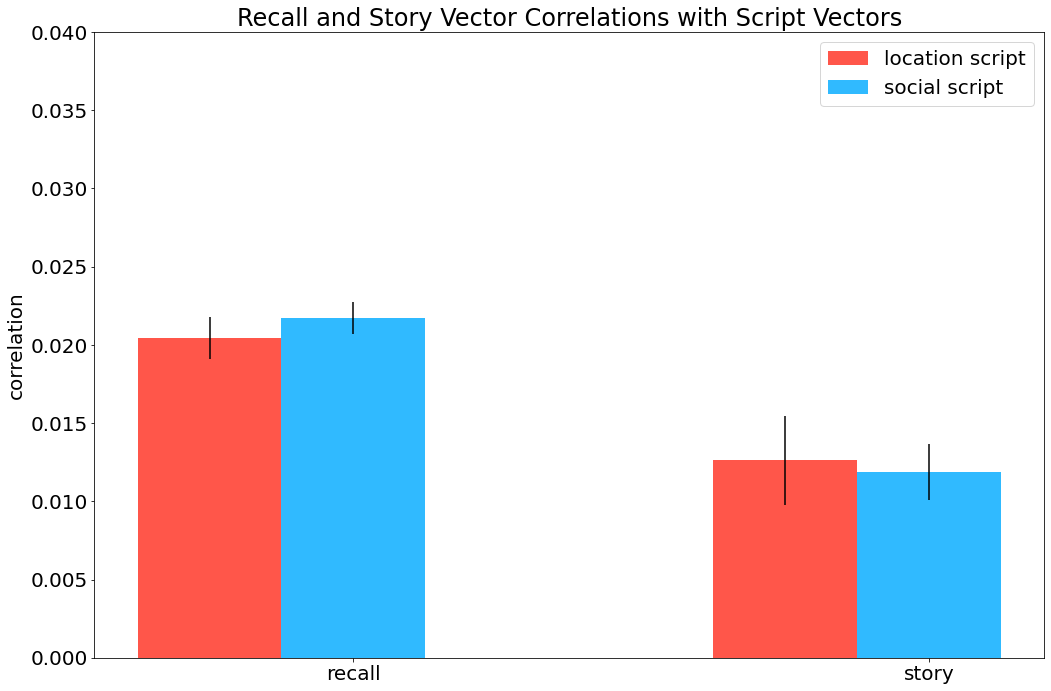

In [30]:
plt.rcParams.update({'font.size': 20})
# loc correlation
loc_plot = np.zeros((2,1))

# soc correlation
soc_plot = np.zeros((2,1))

# assign values
# correlation with loc
loc_plot[0] = mean_re_loc
loc_plot[1] = mean_story_loc


#proportion that are soc
soc_plot[0] = mean_re_soc
soc_plot[1] = mean_story_soc

# SD
loc_sd = (SDre_loc, SDst_loc)
soc_sd = (SDre_soc, SDst_soc)

loc_plot = loc_plot.ravel()
soc_plot = soc_plot.ravel()

#labels
labels = ['recall', 'story']

x = np.arange(len(labels))  # the label locations
width = 0.25  # the width of the bars

fig, ax = plt.subplots(figsize=(15,10))

rects1 = ax.bar(x, loc_plot, width, label='location script', color = '#ff564a', yerr = loc_sd)
rects2 = ax.bar(x + width, soc_plot, width, label='social script', color = '#30baff', yerr = soc_sd)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('correlation')
ax.set_title('Recall and Story Vector Correlations with Script Vectors')
ax.set_xticks(x + width)
ax.set_xticklabels(labels)
ax.legend()
ax.set_ylim([0, .04])
fig.tight_layout()
plt.savefig('templates.png')
plt.show()

# Make a violin plot of the above data

In [31]:
# Making empty dataframe
df = pd.DataFrame(columns = ['corr_value', 'WV_Type', 'Template'])



# Iterate through stories
for story in story_avgs_loc:
    df.loc[len(df.index)] = [story_avgs_loc[story], 'story', 'loc'] 
    df.loc[len(df.index)] = [story_avgs_soc[story], 'story', 'soc'] 
    


In [32]:
# Making empty dataframe
df = pd.DataFrame(columns = ['corr_value', 'WV_Type', 'Template'])

# Iterate through recalls
for i in range(0, len(mloc_re)):
    df.loc[len(df.index)] = [mloc_re[i], 'recall', 'loc'] 
    df.loc[len(df.index)] = [msoc_re[i], 'recall', 'soc'] 

In [33]:
Means = df.groupby('Template')['corr_value'].mean()

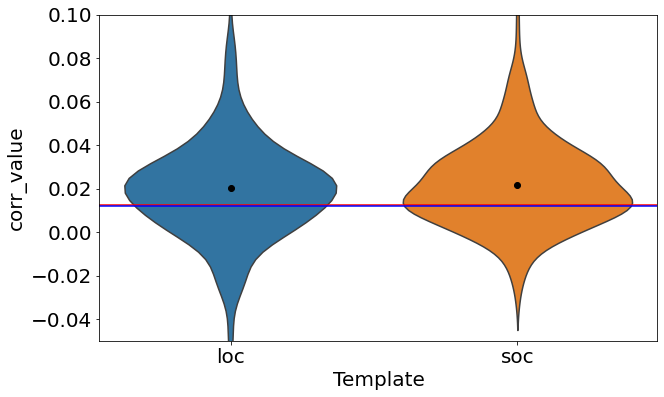

In [34]:
plt.figure(figsize=(10,6))
sns.violinplot(x='Template', y='corr_value',
                    data=df, inner=None)
plt.scatter(x=range(len(Means)),y=Means,c="k")
plt.ylim((-.05, .1))
plt.axhline(y=mean_story_loc, color='r')
plt.axhline(y=mean_story_soc, color='b')

In [35]:
df.to_csv('recallstorycorr.csv', index=False)

In [36]:
# Concat loc cors and soc cors means for each participant
mloc_re_np = []
msoc_re_np = []
mloc_re_loc = []
msoc_re_loc = []
mloc_re_soc = []
msoc_re_soc = []

loc_list = [mloc_re_np, mloc_re_loc, mloc_re_soc]
soc_list = [msoc_re_np, msoc_re_loc, msoc_re_soc]


for story in re_loc_cors:
    for i in range(0,3):
        for participant in re_loc_cors[story][i]:
            loc_list[i].append(np.mean(re_loc_cors[story][i][participant]))
            soc_list[i].append(np.mean(re_soc_cors[story][i][participant]))
            
#find the mean
mean_re_loc = np.mean(np.array(mloc_re))
mean_re_soc = np.mean(np.array(msoc_re))

MEANmloc_re_np = np.mean(np.array(mloc_re_np))
MEAmsoc_re_np = np.mean(np.array(msoc_re_np))
MEAmloc_re_loc = np.mean(np.array(mloc_re_loc))
MEAmsoc_re_loc = np.mean(np.array(msoc_re_loc))
MEAmloc_re_soc = np.mean(np.array(mloc_re_soc))
MEAmsoc_re_soc = np.mean(np.array(msoc_re_soc))

SDloc_re_np = stats.sem(np.array(mloc_re_np))
SDsoc_re_np = stats.sem(np.array(msoc_re_np))
SDloc_re_loc = stats.sem(np.array(mloc_re_loc))
SDsoc_re_loc = stats.sem(np.array(msoc_re_loc))
SDloc_re_soc = stats.sem(np.array(mloc_re_soc))
SDsoc_re_soc =stats.sem(np.array(msoc_re_soc))

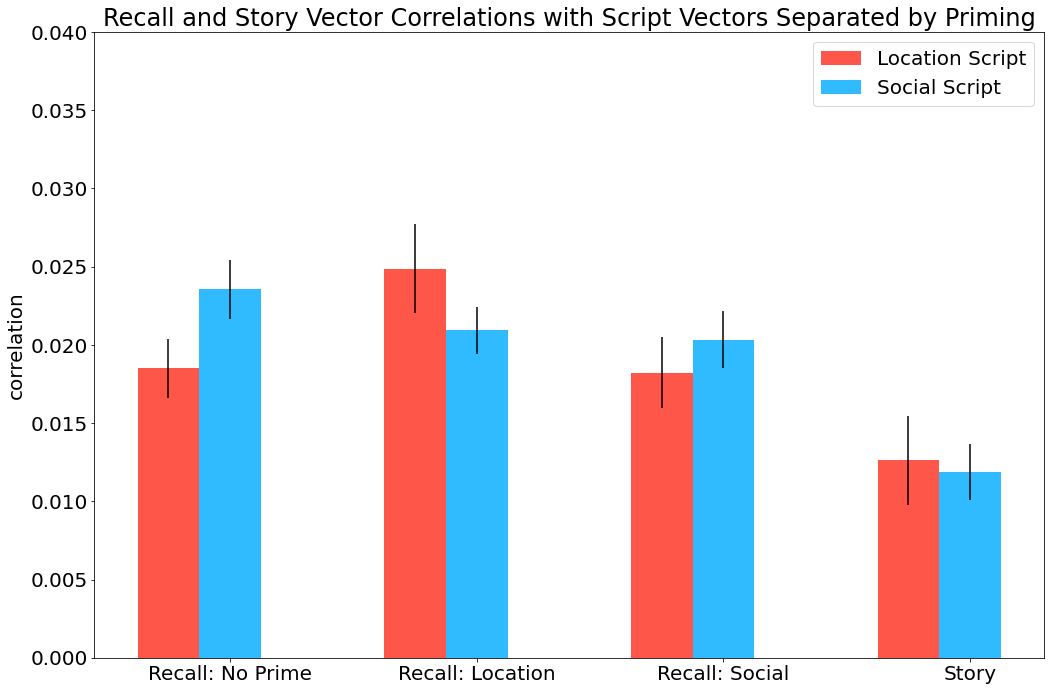

In [40]:
# loc correlation
loc_plot = np.zeros((4,1))

# soc correlation
soc_plot = np.zeros((4,1))

# assign values
# correlation with loc
loc_plot[0] = MEANmloc_re_np
loc_plot[1] = MEAmloc_re_loc
loc_plot[2] = MEAmloc_re_soc
loc_plot[3] = mean_story_loc


#proportion that are soc
soc_plot[0] = MEAmsoc_re_np
soc_plot[1] = MEAmsoc_re_loc
soc_plot[2] = MEAmsoc_re_soc
soc_plot[3] = mean_story_soc

loc_plot = loc_plot.ravel()
soc_plot = soc_plot.ravel()

# SD
loc_sd = (SDloc_re_np, SDloc_re_loc, SDloc_re_soc, SDst_loc)
soc_sd = (SDsoc_re_np, SDsoc_re_loc, SDsoc_re_soc, SDst_soc)

#labels
labels = ['Recall: No Prime', 'Recall: Location', 'Recall: Social', 'Story']

x = np.arange(len(labels))  # the label locations
width = 0.25  # the width of the bars

fig, ax = plt.subplots(figsize=(15,10))

rects1 = ax.bar(x, loc_plot, width, label='Location Script', color = '#ff564a', yerr = loc_sd)
rects2 = ax.bar(x + width, soc_plot, width, label='Social Script', color = '#30baff', yerr = soc_sd)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('correlation')
ax.set_title('Recall and Story Vector Correlations with Script Vectors Separated by Priming')
ax.set_xticks(x + width)
ax.set_xticklabels(labels)
ax.legend()
ax.set_ylim([0, .04])
fig.tight_layout()
plt.savefig('corr.png')
plt.show()




In [41]:
# Making empty dataframe
df = pd.DataFrame(columns = ['corr', 'priming'])

# Iterating through recalls and subtracting story avgs
for story in re_loc_cors:
    for i in range(0,3):
        if i == 0:
            this_prime = 'np'
        elif i == 1:
            this_prime = 'loc'
        else:
            this_prime = 'soc'
        for participant in re_loc_cors[story][i]:
            df.loc[len(df.index)] = [np.mean(re_loc_cors[story][i][participant]), this_prime]

df.to_csv('locCor.csv', index=False)

## Testing the Schema effect
### Subtracting the story correlations from the recall correlations and seeing if this difference is significantly above 0. If it is, it would indicate to us that the recall is more schematic than the stories themselves, because the recall words have higher correlation with the schema templates


In [42]:
# Prepare story values by avging correlations of each story together

story_avgs_loc = {}
story_avgs_soc = {}

for story in loc_cors.keys():
    story_avgs_loc[story] = np.mean(loc_cors[story])
    story_avgs_soc[story] = np.mean(soc_cors[story])

In [43]:
sub_count = 1
export_matrix = np.zeros((0, 4))

for story in re_loc_cors:
    for i in range(0,3):
        if i == 0:
            priming = 'np'
        elif i == 1:
            priming = 'loc'
        else:
            priming = 'soc'
        for participant in re_loc_cors[story][i]:
            mean_loc = np.mean(re_loc_cors[story][i][participant]) - story_avgs_loc[story]
            mean_soc = np.mean(re_soc_cors[story][i][participant]) - story_avgs_soc[story]
            this_array1 = np.array([priming, 'loc_cor', mean_loc, sub_count])
            this_array2 = np.array([priming, 'soc_cor', mean_soc, sub_count])
            export_matrix = np.vstack((export_matrix, this_array1))
            export_matrix = np.vstack((export_matrix, this_array2))
            sub_count += 1

In [44]:
story_avgs_loc

{32: 0.014350679308535874,
 34: 0.026515772324999475,
 33: 0.02066358050719472,
 11: -0.0035531264546330306,
 42: 0.019235550466767292,
 21: 0.004858152118024927,
 44: 0.02285533033046158,
 43: 0.004939065583432199,
 31: -0.008239688994474576,
 41: 0.0022151390702075794,
 24: 0.029156066604889393,
 23: 0.010776725506993868,
 12: 0.01618876342133892,
 13: -0.00024756865475405234,
 14: 0.020433865830813462,
 22: 0.021776038765362354}

In [45]:
np.savetxt('storyrecall_DIF.csv', export_matrix, delimiter=',', fmt='%s', header='priming,cor_type,dif, sub', comments='')

In [46]:
Means

Template
loc    0.020428
soc    0.021709
Name: corr_value, dtype: float64

## Plotting recall/story differences
### 1. violin plot

In [47]:
# Making empty dataframe
df = pd.DataFrame(columns = ['boost', 'priming', 'Template'])

# Iterating through recalls and subtracting story avgs
for story in re_loc_cors:
    for i in range(0,3):
        if i == 0:
            this_prime = 'np'
        elif i == 1:
            this_prime = 'loc'
        else:
            this_prime = 'soc'
        for participant in re_loc_cors[story][i]:
            df.loc[len(df.index)] = [np.mean(re_loc_cors[story][i][participant]) - story_avgs_loc[story], this_prime, 'loc']
            df.loc[len(df.index)] = [np.mean(re_soc_cors[story][i][participant]) - story_avgs_soc[story], this_prime, 'soc']

In [48]:
df.to_csv('schemaboost.csv', index=False)

(-0.05, 0.1)

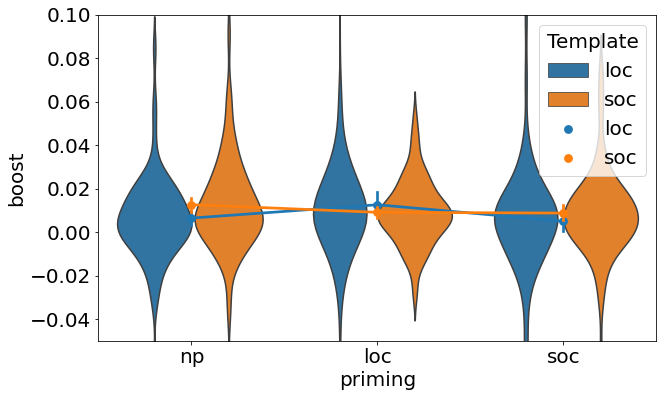

In [49]:
from numpy import mean
# calculate the means
Means = df.groupby(['priming','Template'])['boost'].mean()

plt.figure(figsize=(10,6))
sns.violinplot(x='priming', y='boost', hue = 'Template', points=40, widths=0.5,
                    data=df, inner=None, showmeans = True)

sns.pointplot(x = 'priming', y='boost',hue = 'Template', data=df, estimator=mean)

plt.ylim((-.05, .1))

(-0.05, 0.1)

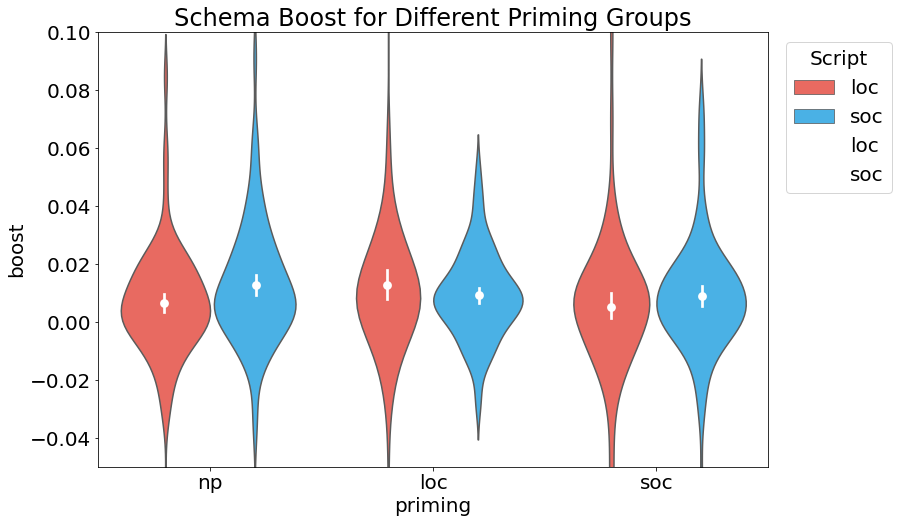

In [50]:
plt.rcParams.update({'font.size': 20})
fig, ax = plt.subplots(1, figsize=[12,8])

sns.violinplot(x='priming', y='boost', hue = 'Template', points=40, widths=0.5,
                    data=df, inner=None, ax = ax, showmeans = True, palette = ['#ff564a', '#30baff'])

sns.pointplot(x='priming', y='boost', hue = 'Template',
                   data=df, dodge=0.41, ax=ax, join=False, palette=['white'], label=False)

plt.title('Schema Boost for Different Priming Groups')
plt.legend(title = 'Script', bbox_to_anchor = (1.2, 1))
plt.ylim((-.05, .1))

In [177]:
Means

priming  Template
loc      loc         0.012574
         soc         0.009085
np       loc         0.006434
         soc         0.012605
soc      loc         0.004958
         soc         0.008747
Name: boost, dtype: float64

### 2. bar plot

In [96]:
locdif_np = []
socdif_np = []
locdif_loc = []
socdif_loc = []
locdif_soc = []
socdif_soc = []

loc_dif = [locdif_np,locdif_loc,locdif_soc]
soc_dif =[socdif_np,socdif_loc,socdif_soc]

for story in re_loc_cors:
    for i in range(0,3):
        for participant in re_loc_cors[story][i]:
            loc_dif[i].append(np.mean(re_loc_cors[story][i][participant]) - story_avgs_loc[story])
            soc_dif[i].append(np.mean(re_soc_cors[story][i][participant]) - story_avgs_soc[story])
            
Mlocdif_np = np.mean(np.array(locdif_np))
Msocdif_np = np.mean(np.array(socdif_np))
Mlocdif_loc = np.mean(np.array(locdif_loc))
Msocdif_loc = np.mean(np.array(socdif_loc))
Mlocdif_soc = np.mean(np.array(locdif_soc))
Msocdif_soc = np.mean(np.array(socdif_soc))

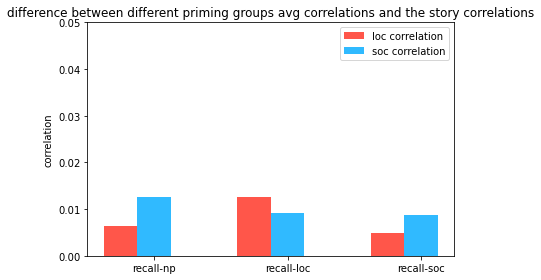

In [165]:
# loc correlation
loc_plot = np.zeros((3,1))

# soc correlation
soc_plot = np.zeros((3,1))

# assign values
# correlation with loc
loc_plot[0] = Mlocdif_np
loc_plot[1] = Mlocdif_loc
loc_plot[2] = Mlocdif_soc

#proportion that are soc
soc_plot[0] = Msocdif_np
soc_plot[1] = Msocdif_loc
soc_plot[2] = Msocdif_soc

loc_plot = loc_plot.ravel()
soc_plot = soc_plot.ravel()

#labels
labels = ['recall-np', 'recall-loc', 'recall-soc']

x = np.arange(len(labels))  # the label locations
width = 0.25  # the width of the bars

fig, ax = plt.subplots()

rects1 = ax.bar(x, loc_plot, width, label='loc correlation', color = '#ff564a')
rects2 = ax.bar(x + width, soc_plot, width, label='soc correlation', color = '#30baff')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('correlation')
ax.set_title('difference between different priming groups avg correlations and the story correlations')
ax.set_xticks(x + width)
ax.set_xticklabels(labels)
ax.legend()
ax.set_ylim([0, .05])
fig.tight_layout()
plt.savefig('corr.png')
plt.show()




# CORRELATION between # of words in a recall and avg correlation of all words in a recall with loc or soc template

In [82]:
num_corrL = np.zeros((0, 2))
num_corrS = np.zeros((0, 2))

for story in re_loc_cors:
    for i in range(0,3):
        for participant in re_loc_cors[story][i]:
            # Loc count
            this_array = np.array([re_loc_cors[story][i][participant].shape[0], np.mean(re_loc_cors[story][i][participant])])
            num_corrL = np.vstack((num_corrL, this_array))
            # Soc count
            this_array = np.array([re_soc_cors[story][i][participant].shape[0], np.mean(re_soc_cors[story][i][participant])])
            num_corrS = np.vstack((num_corrS, this_array))

The loc correlation is  -0.10020467475156446
The soc correlation is  -0.22998499677429066


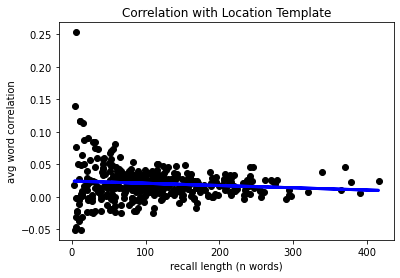

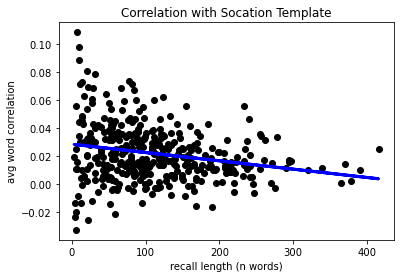

In [83]:
# LOC

# Create linear regression object
regr = linear_model.LinearRegression()

numW = num_corrL[:,0]
avgC = num_corrL[:,1]

x = numW.reshape(numW.shape[0],-1)
y = avgC.reshape(avgC.shape[0],-1)

# Train the model using the training sets
regr.fit(x, y)

# Make predictions using the testing set
pred_y = regr.predict(x)
    
plt.plot(x, y, 'o', color='black')
plt.plot(x, pred_y, color='blue', linewidth=3)
plt.xlabel('recall length (n words)')
plt.ylabel('avg word correlation')
plt.title('Correlation with Location Template')

this_correl = np.corrcoef(numW.T, avgC.T)
correl = this_correl[0,1]
print('The loc correlation is ', correl)

# SOC
plt.figure()

# Create linear regression object
regr = linear_model.LinearRegression()

numW = num_corrS[:,0]
avgC = num_corrS[:,1]

x = numW.reshape(numW.shape[0],-1)
y = avgC.reshape(avgC.shape[0],-1)

# Train the model using the training sets
regr.fit(x, y)

# Make predictions using the testing set
pred_y = regr.predict(x)
    
plt.plot(x, y, 'o', color='black')
plt.plot(x, pred_y, color='blue', linewidth=3)
plt.xlabel('recall length (n words)')
plt.ylabel('avg word correlation')
plt.title('Correlation with Socation Template')

this_correl = np.corrcoef(numW.T, avgC.T)
correl = this_correl[0,1]
print('The soc correlation is ', correl)

In [181]:
x = np.zeros((16))
y = np.zeros((16))

In [182]:
x.shape

(16,)

In [184]:
num_corrL[:,0].shape

(315,)